# [House Price Predicting]('https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview')

### `File Descriptions:`

### **Goal**

* It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### **Metrics**

* Submissions are evaluated on Root-Mean-Squared-Error (RMSE)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy.stats as st
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10.0, 8.0)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## `1. Exploratory Data Analysis`

### `Loading Data`

In [2]:
df_train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

In [3]:
display(df_train.head(), df_test.tail())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [4]:
df_train.shape , df_test.shape

((1460, 81), (1459, 80))

In [5]:
df_all = pd.concat([df_train, df_test]).reset_index(drop = True)
y_train_org = df_train[['SalePrice']]
df_all

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [7]:
df_all.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


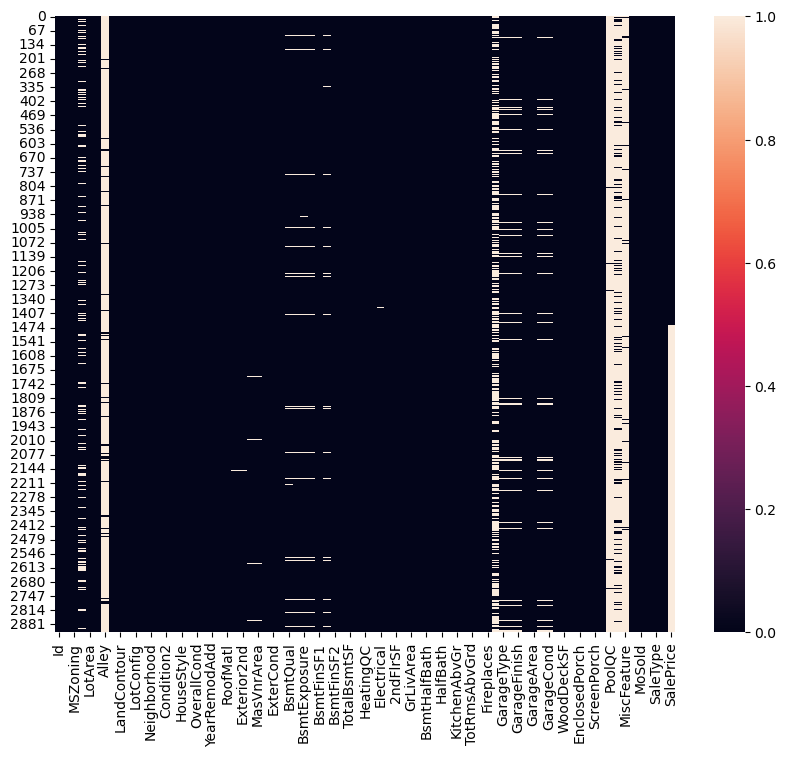

In [8]:
sns.heatmap(df_all.isnull());

### `Categorical Columns`

In [9]:
cateogrical_columns = df_all.select_dtypes(exclude=[np.number])
categorical_names = cateogrical_columns.columns.tolist()
print("The number of categorical feature is ", cateogrical_columns.shape[1])

The number of categorical feature is  43


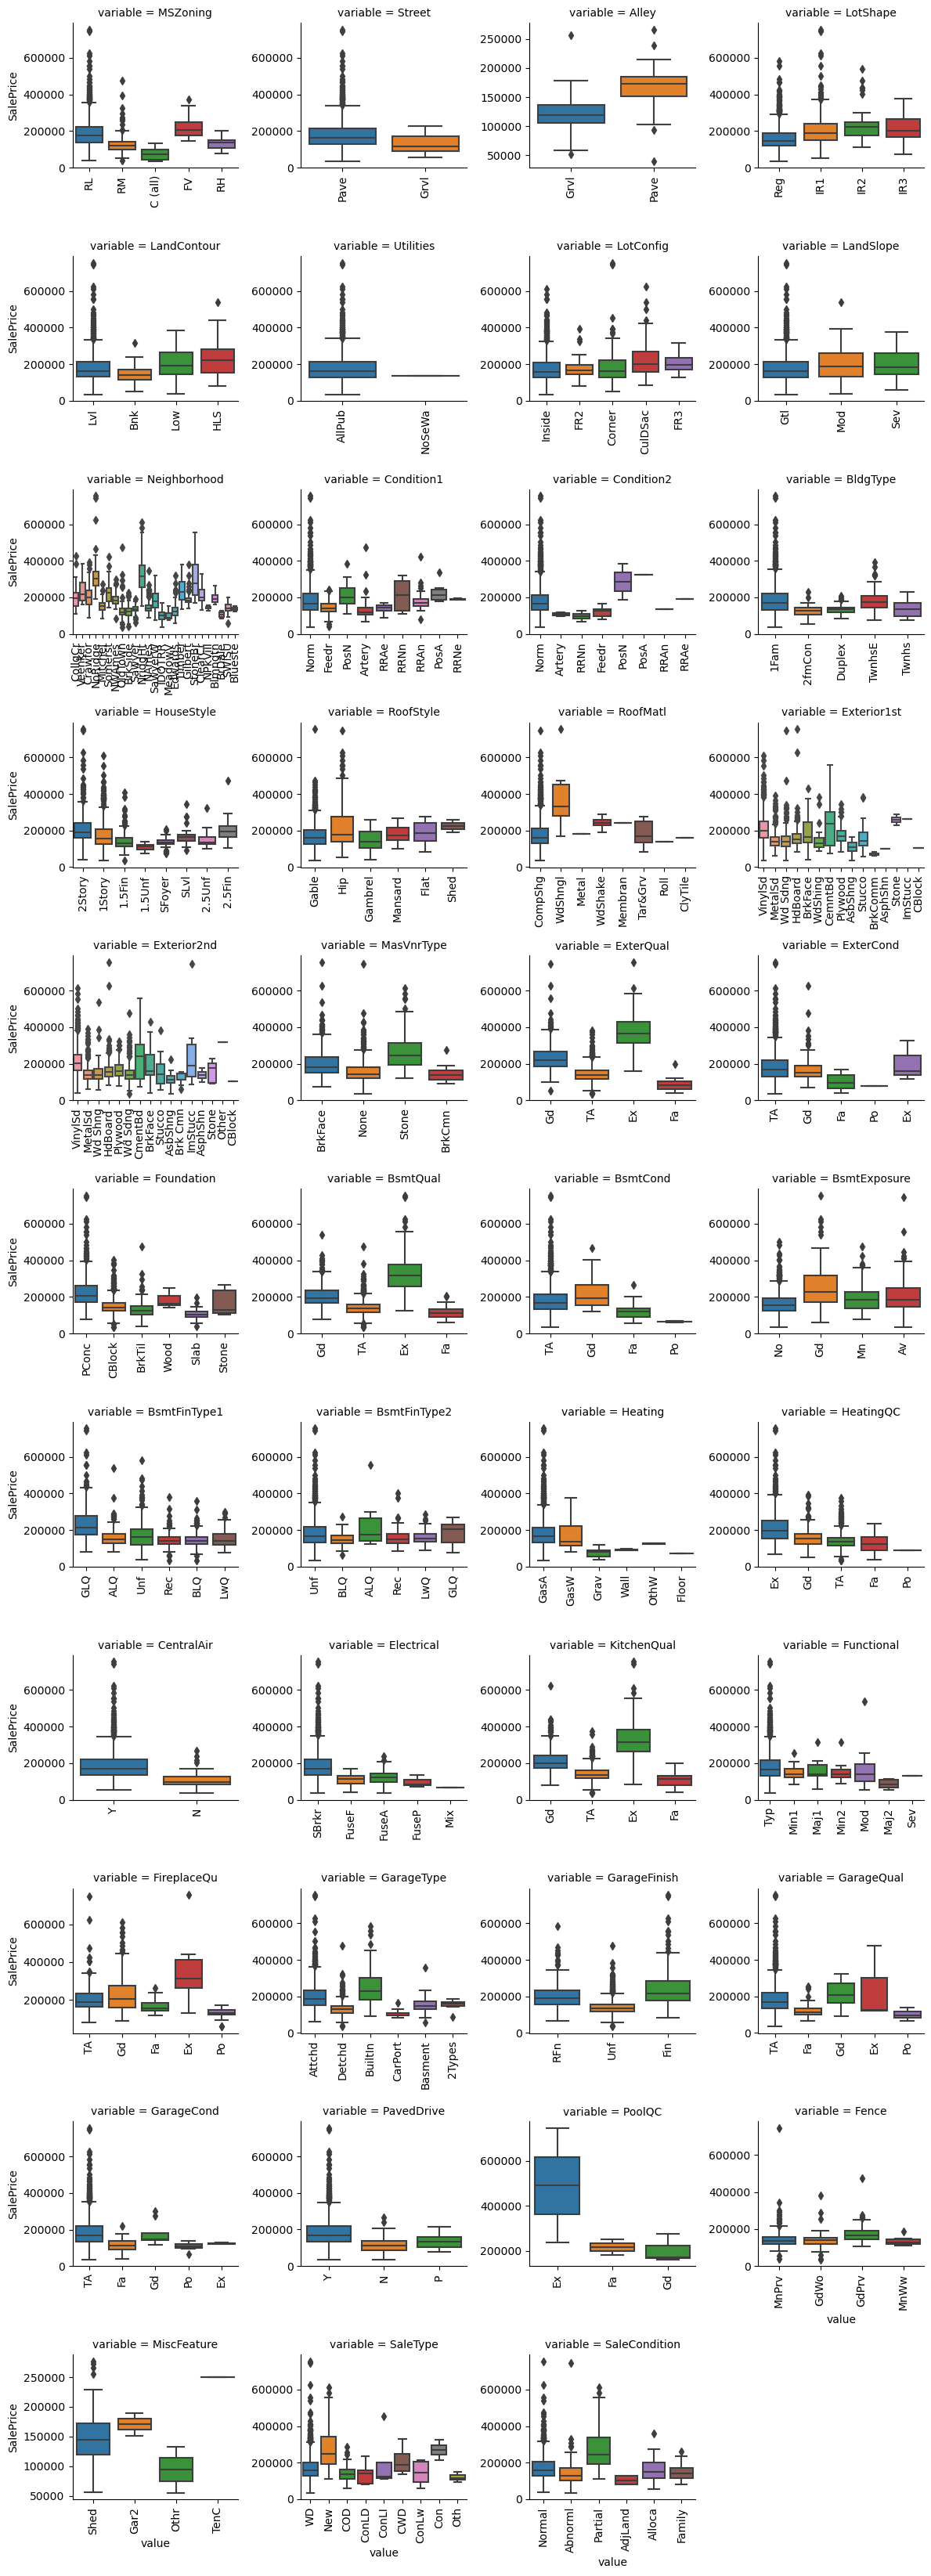

In [10]:
def boxplot(x,y, **kws):
    sns.boxplot(x=x, y=y)
    plt.xticks(rotation=90)
    
f = pd.melt(frame = df_train,id_vars=['SalePrice'], value_vars = categorical_names)
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(boxplot,'value','SalePrice')

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600')])

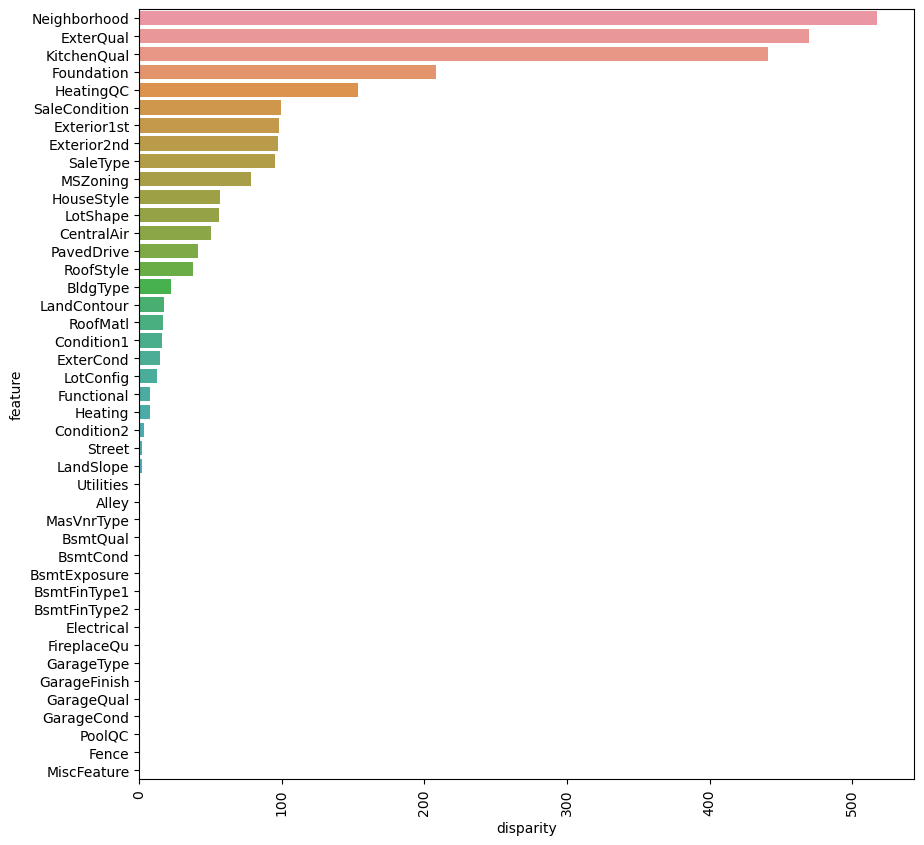

In [11]:
def anova(frame):
    '''
    - ANOVA is a statistical method used to determine 
    if there are any statistically significant differences 
    between the means of three or more independent (unrelated) groups
    '''
    anv = pd.DataFrame()
    anv['feature'] = categorical_names
    p_values=[]
    
    for obj in categorical_names:
        
        samples=[] # accessor for SalePrices related to each values
        
        for values in frame[obj].unique():
            samples.append(frame[frame[obj]==values]['SalePrice'].values)
            
        p_values.append(st.f_oneway(*samples)[1]) 
        #one-way analysis of variance (ANOVA) is returned p-value <threshold meaning that \
        #There is a significant difference between the group means.")
        
    anv['p_values'] = p_values
    
    return(anv.sort_values(by='p_values'))


fig, ax = plt.subplots(figsize=(10,10))
a = anova(df_train)
a['disparity'] = np.log(1.0/a['p_values'].values)# large disparty value indicate ignificant difference
sns.barplot(data=a, y='feature', x='disparity', orient='h')
plt.xticks(rotation=90)

### `Numerical Columns`

In [12]:
numerical_columns = df_all.select_dtypes(include=[np.number])
numerical_columns.drop(['Id','SalePrice'], axis = 1, inplace=True)
numerical_names = numerical_columns.columns.tolist()
print("The number of numeric feature is ", numerical_columns.shape[1])

The number of numeric feature is  36


     variable  value
0  MSSubClass   60.0
1  MSSubClass   20.0
2  MSSubClass   60.0
3  MSSubClass   70.0
4  MSSubClass   60.0


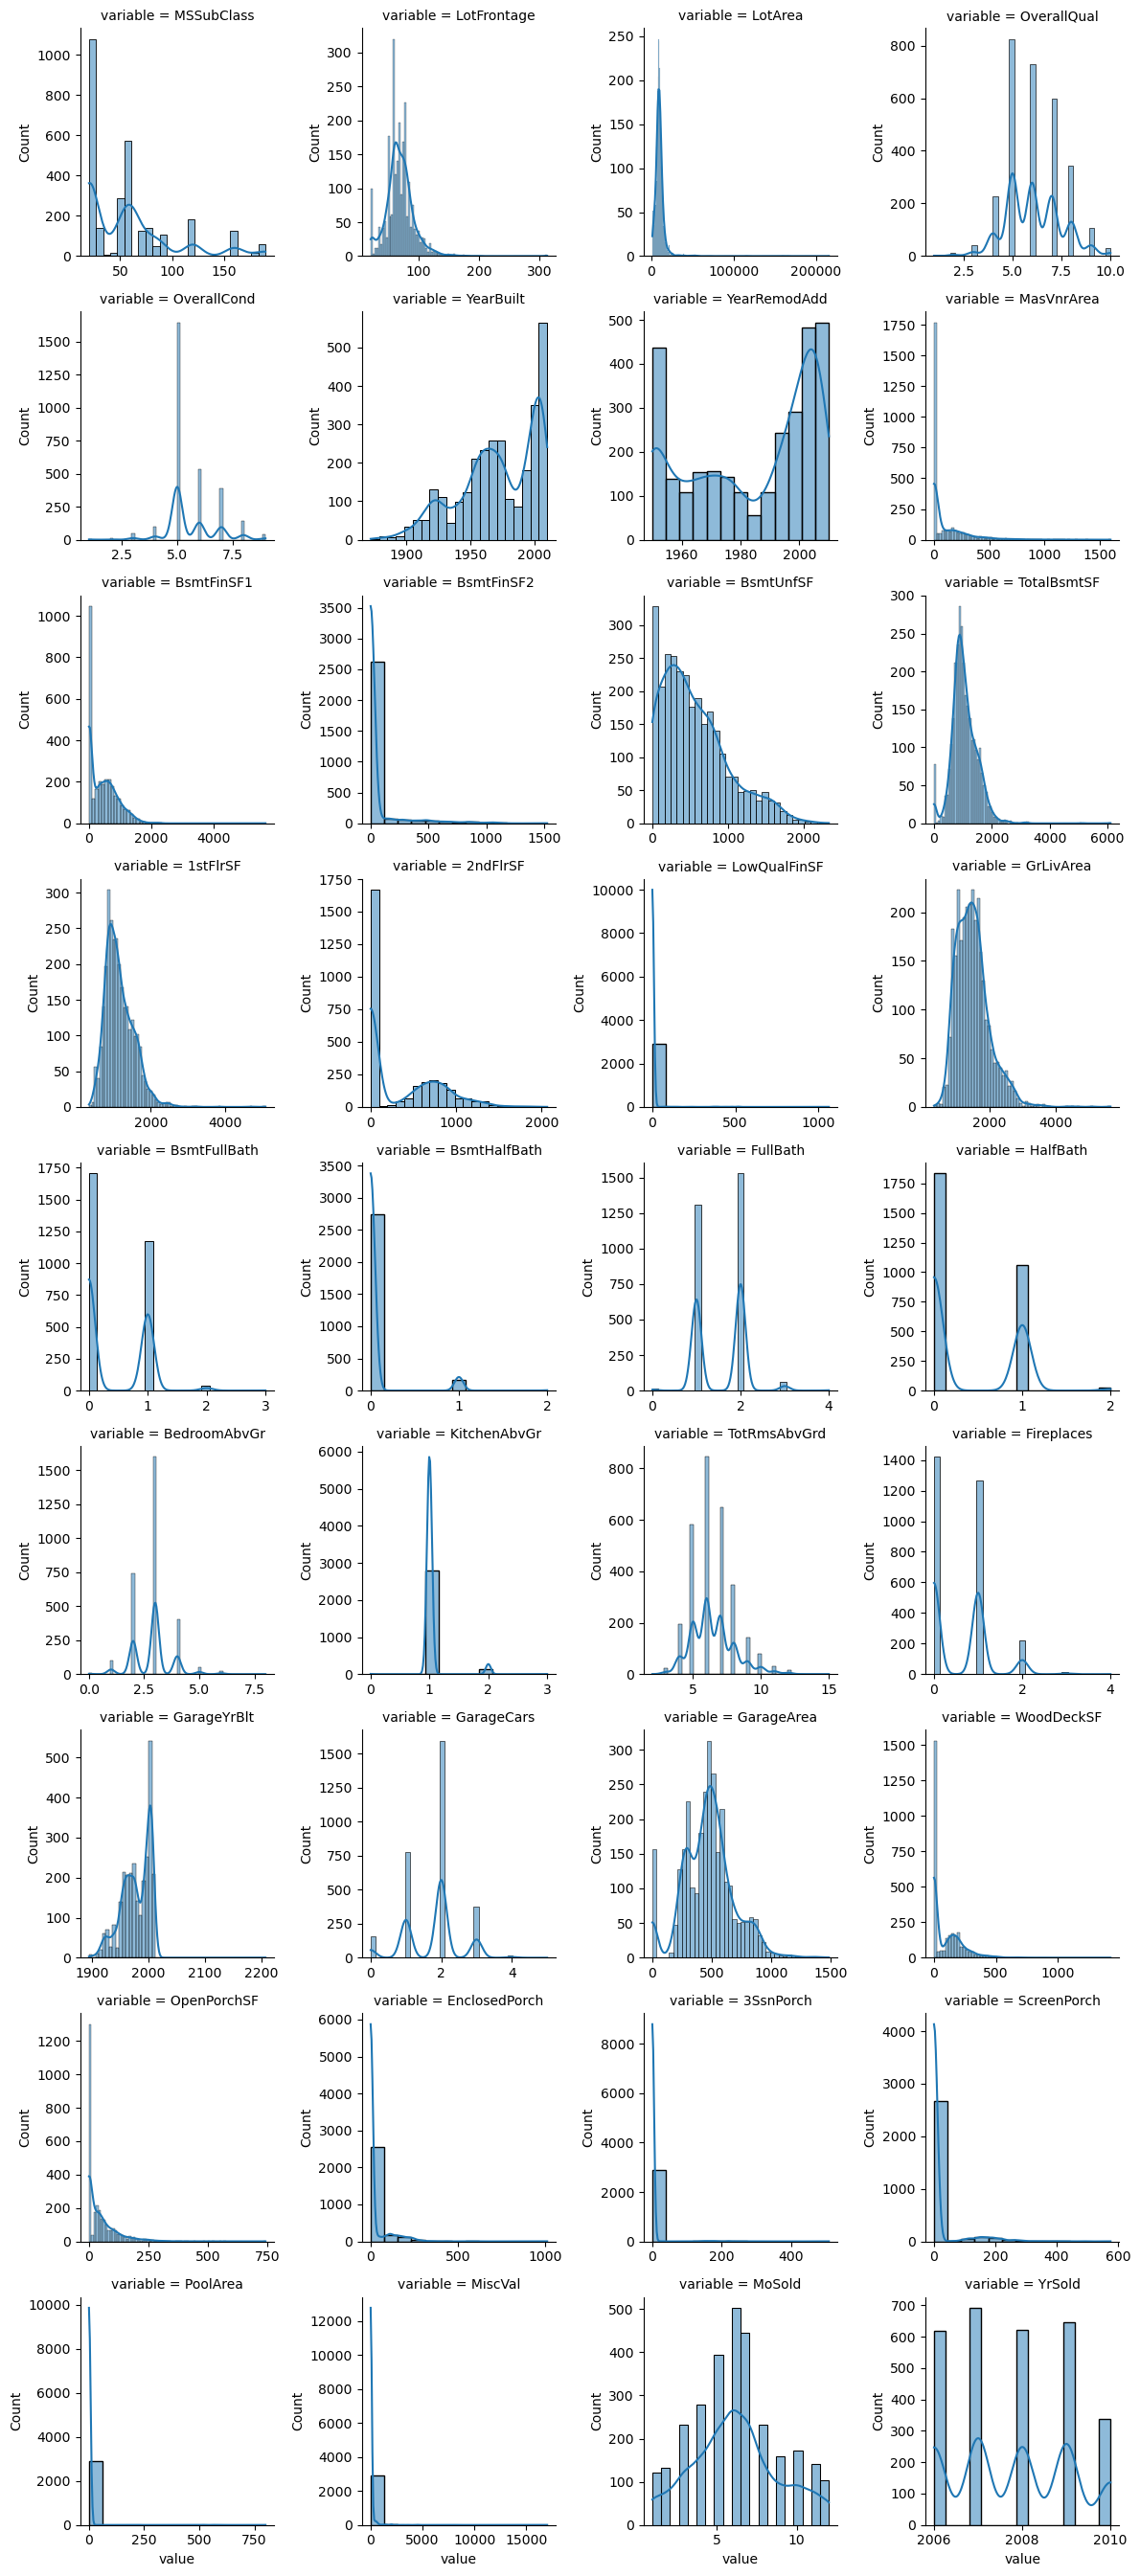

In [13]:
f = pd.melt(df_all, value_vars = numerical_names)
print(f.head())
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, "value", kde=True )

YearRemodAdd  YearBuilt       0.612235
1stFlrSF      TotalBsmtSF     0.801670
GrLivArea     2ndFlrSF        0.655085
BsmtFullBath  BsmtFinSF1      0.638847
FullBath      GrLivArea       0.630286
HalfBath      2ndFlrSF        0.611362
TotRmsAbvGrd  GrLivArea       0.808354
              BedroomAbvGr    0.669737
GarageYrBlt   YearBuilt       0.834812
              YearRemodAdd    0.652365
GarageCars    OverallQual     0.600744
GarageArea    GarageCars      0.889700
dtype: float64


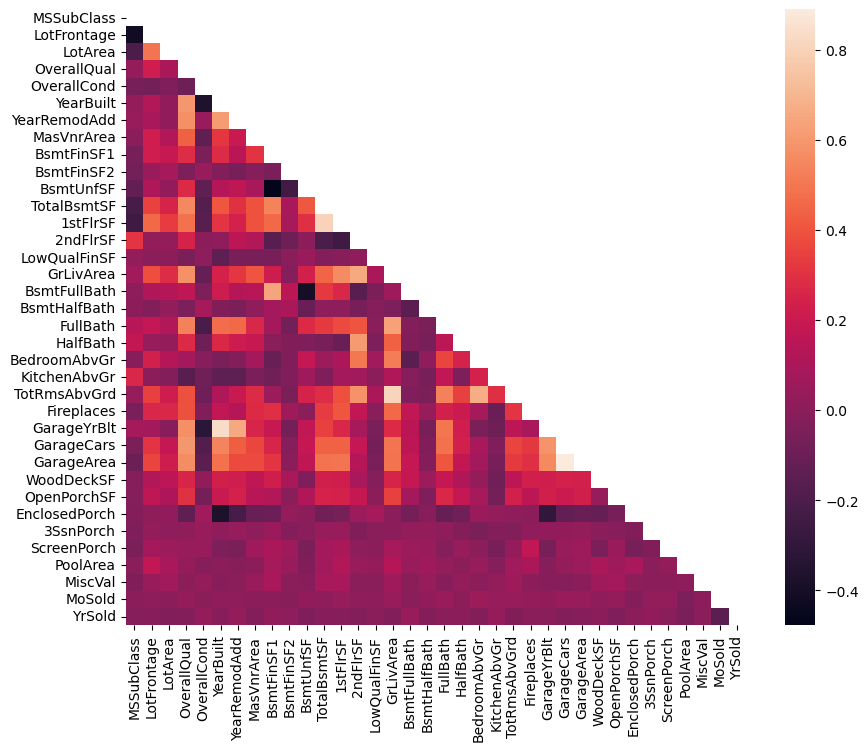

In [14]:
#plot correlation map
corr = numerical_columns.corr()
mask = np.zeros_like(corr, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True
fig, ax1 = plt.subplots()
sns.heatmap(corr, mask=mask, ax=ax1)

corr2 = corr.mask(np.triu(np.ones(corr.shape)).astype(np.bool_))
print(corr2[corr2.abs()>0.6].stack())

[[1.         0.7909816  0.70862448 0.6404092  0.62343144 0.61358055
  0.60585218 0.56066376 0.53372316 0.52289733]
 [0.7909816  1.         0.59300743 0.60067072 0.56202176 0.5378085
  0.47622383 0.55059971 0.42745234 0.57232277]
 [0.70862448 0.59300743 1.         0.46724742 0.46899748 0.4548682
  0.56602397 0.63001165 0.82548937 0.19900971]
 [0.6404092  0.60067072 0.46724742 1.         0.88247541 0.43458483
  0.43931681 0.46967204 0.36228857 0.53785009]
 [0.62343144 0.56202176 0.46899748 0.88247541 1.         0.48666546
  0.48978165 0.40565621 0.33782212 0.47895382]
 [0.61358055 0.5378085  0.4548682  0.43458483 0.48666546 1.
  0.81952998 0.32372241 0.28557256 0.391452  ]
 [0.60585218 0.47622383 0.56602397 0.43931681 0.48978165 0.81952998
  1.         0.38063749 0.40951598 0.28198586]
 [0.56066376 0.55059971 0.63001165 0.46967204 0.40565621 0.32372241
  0.38063749 1.         0.55478425 0.46827079]
 [0.53372316 0.42745234 0.82548937 0.36228857 0.33782212 0.28557256
  0.40951598 0.5547842

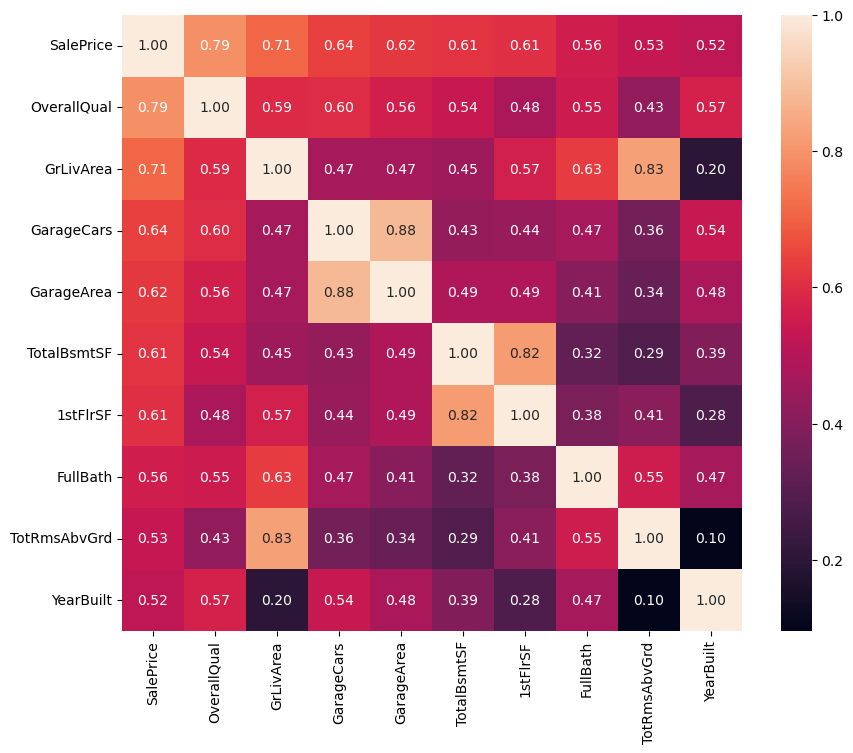

In [15]:
# # the correlations of numericla features with y_train_org
xy_train = pd.concat([numerical_columns[:df_train.shape[0]], y_train_org], axis=1)

fig, ax = plt.subplots()
corr_y_train = xy_train.corr()
k = 10 # top 10 variable for plotting heatmap
 
cols = corr_y_train.nlargest(k,'SalePrice')['SalePrice'].index
 
cm = np.corrcoef(xy_train[cols].values.T)
sns.heatmap(cm,cbar=True,annot=True,fmt='.2f', annot_kws={'size':10},\
            yticklabels=cols.values,xticklabels=cols.values,\
           ax=ax)
print(cm)

### `Fill Missing Values`

#### droping SalePrice

In [16]:
df_all.drop('SalePrice', axis=1, inplace=True)

In [17]:
missing_cols = [(features, df_all[features].isnull().sum(), df_all[features].dtype) 
                  for features in df_all.columns if df_all[features].isnull().sum() > 0]


sorted_missing_cols = sorted(missing_cols, key=lambda x: -x[1])
sorted_missing_cols

[('PoolQC', 2909, dtype('O')),
 ('MiscFeature', 2814, dtype('O')),
 ('Alley', 2721, dtype('O')),
 ('Fence', 2348, dtype('O')),
 ('FireplaceQu', 1420, dtype('O')),
 ('LotFrontage', 486, dtype('float64')),
 ('GarageYrBlt', 159, dtype('float64')),
 ('GarageFinish', 159, dtype('O')),
 ('GarageQual', 159, dtype('O')),
 ('GarageCond', 159, dtype('O')),
 ('GarageType', 157, dtype('O')),
 ('BsmtCond', 82, dtype('O')),
 ('BsmtExposure', 82, dtype('O')),
 ('BsmtQual', 81, dtype('O')),
 ('BsmtFinType2', 80, dtype('O')),
 ('BsmtFinType1', 79, dtype('O')),
 ('MasVnrType', 24, dtype('O')),
 ('MasVnrArea', 23, dtype('float64')),
 ('MSZoning', 4, dtype('O')),
 ('Utilities', 2, dtype('O')),
 ('BsmtFullBath', 2, dtype('float64')),
 ('BsmtHalfBath', 2, dtype('float64')),
 ('Functional', 2, dtype('O')),
 ('Exterior1st', 1, dtype('O')),
 ('Exterior2nd', 1, dtype('O')),
 ('BsmtFinSF1', 1, dtype('float64')),
 ('BsmtFinSF2', 1, dtype('float64')),
 ('BsmtUnfSF', 1, dtype('float64')),
 ('TotalBsmtSF', 1, dtype(

In [18]:
# Many missing values
df_all.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

# Dates
df_all.drop(['GarageYrBlt'], axis=1, inplace=True)

In [19]:
missing_cols = [(features, df_all[features].isnull().sum(), df_all[features].dtype) 
                  for features in df_all.columns if df_all[features].isnull().sum() > 0]

sorted_missing_cols = sorted(missing_cols, key=lambda x: x[2])
sorted_missing_cols

[('LotFrontage', 486, dtype('float64')),
 ('MasVnrArea', 23, dtype('float64')),
 ('BsmtFinSF1', 1, dtype('float64')),
 ('BsmtFinSF2', 1, dtype('float64')),
 ('BsmtUnfSF', 1, dtype('float64')),
 ('TotalBsmtSF', 1, dtype('float64')),
 ('BsmtFullBath', 2, dtype('float64')),
 ('BsmtHalfBath', 2, dtype('float64')),
 ('GarageCars', 1, dtype('float64')),
 ('GarageArea', 1, dtype('float64')),
 ('MSZoning', 4, dtype('O')),
 ('Utilities', 2, dtype('O')),
 ('Exterior1st', 1, dtype('O')),
 ('Exterior2nd', 1, dtype('O')),
 ('MasVnrType', 24, dtype('O')),
 ('BsmtQual', 81, dtype('O')),
 ('BsmtCond', 82, dtype('O')),
 ('BsmtExposure', 82, dtype('O')),
 ('BsmtFinType1', 79, dtype('O')),
 ('BsmtFinType2', 80, dtype('O')),
 ('Electrical', 1, dtype('O')),
 ('KitchenQual', 1, dtype('O')),
 ('Functional', 2, dtype('O')),
 ('FireplaceQu', 1420, dtype('O')),
 ('GarageType', 157, dtype('O')),
 ('GarageFinish', 159, dtype('O')),
 ('GarageQual', 159, dtype('O')),
 ('GarageCond', 159, dtype('O')),
 ('SaleType', 

In [20]:
for row in sorted_missing_cols: 
      
      if row[2] == 'object':
            df_all[row[0]] = df_all[row[0]].fillna(df_all[row[0]].mode()[0])

      else:
            df_all[row[0]] = df_all[row[0]].fillna(df_all[row[0]].mean())
            

print('Missing Values: ' , df_all.isna().sum().sum())
print('Shape :' , df_all.shape)

Missing Values:  0
Shape : (2919, 75)


In [23]:
df_all

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,61,0,0,0,0,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,42,0,0,0,0,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,24,0,0,0,0,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,32,0,0,0,0,700,7,2006,WD,Normal


### `Categorical Features One-Hot Encoding`

In [24]:
final_df = pd.get_dummies(df_all)
final_df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2915,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,0,0,0,1,1,0,0,0,0,0
2916,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,0,0,0,1,1,0,0,0,0,0
2917,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,0,0,0,1,0,0,0,0,1,0


## `2. PyTorch`

In [25]:
train_set = torch.tensor(final_df[:df_train.shape[0]].values, dtype=torch.float)
train_target = torch.tensor(y_train_org.values, dtype=torch.float)

In [26]:
train_set.shape[1]

275

This neural network is a feedforward architecture comprising three hidden layers. It takes a 294-dimensional input and processes it through three hidden layers, each consisting of 1024 neurons. The final output is a scalar value (1-dimensional). Dropout operations are employed after each hidden layer to mitigate overfitting. The network's weight initialization utilizes the Xavier initialization method, promoting enhanced convergence during training. Rectified Linear Unit (ReLU) activation functions are applied throughout the network.

In [27]:
class Net(torch.nn.Module):
      
    def __init__(self):
        super(Net,self).__init__()
        self.hidden_layer1 = nn.Linear(275,1024)
        self.hidden_layer2 = nn.Linear(1024,1024)
        self.hidden_layer3 = nn.Linear(1024,1024)
        self.hidden_layer4 = nn.Linear(1024,1024)
        self.output_layer = nn.Linear(1024,1)
        self.dropout = nn.Dropout(p=0.2) 
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        nn.init.xavier_uniform_(self.hidden_layer4.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
        
    def forward(self,x):
        inputs = x
        layer1_out = torch.nn.functional.gelu(self.hidden_layer1(inputs))
        layer1_out = self.dropout(layer1_out)
        layer2_out = torch.nn.functional.gelu(self.hidden_layer2(layer1_out))
        layer2_out = self.dropout(layer2_out)
        layer3_out = torch.nn.functional.gelu(self.hidden_layer3(layer2_out))
        layer3_out = self.dropout(layer3_out)
        layer4_out = torch.nn.functional.gelu(self.hidden_layer4(layer3_out))
        layer4_out = self.dropout(layer4_out)
        output = torch.relu(self.output_layer(layer4_out))
        return output

Train a neural network to predict house prices using the provided architecture. Utilize the Mean Squared Logarithmic Error (MSLE) loss function to prevent bias towards high-priced houses. This maintains prediction balance across various price levels.

In [28]:
model = Net()
model.parameters

<bound method Module.parameters of Net(
  (hidden_layer1): Linear(in_features=275, out_features=1024, bias=True)
  (hidden_layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (hidden_layer3): Linear(in_features=1024, out_features=1024, bias=True)
  (hidden_layer4): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>

In [29]:
loss_function = nn.MSELoss() ## Later convert to RSME
optimizer = optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-3)

In [30]:
EPOCHS = 5001
final_losses = []

for i in range(EPOCHS):
      
    y_pred = model(train_set)
    y_pred.squeeze()
    loss = torch.sqrt(loss_function(y_pred, train_target)) ### RMSE
    final_losses.append(loss.item())
    
    if i%500 == 0:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

Epoch number: 0 and the loss : 197468.0
Epoch number: 500 and the loss : 25919.341796875
Epoch number: 1000 and the loss : 19033.515625
Epoch number: 1500 and the loss : 20948.0546875
Epoch number: 2000 and the loss : 14592.904296875
Epoch number: 2500 and the loss : 17001.267578125
Epoch number: 3000 and the loss : 12571.43359375
Epoch number: 3500 and the loss : 12850.4951171875
Epoch number: 4000 and the loss : 12285.5322265625
Epoch number: 4500 and the loss : 11790.8603515625
Epoch number: 5000 and the loss : 11805.134765625


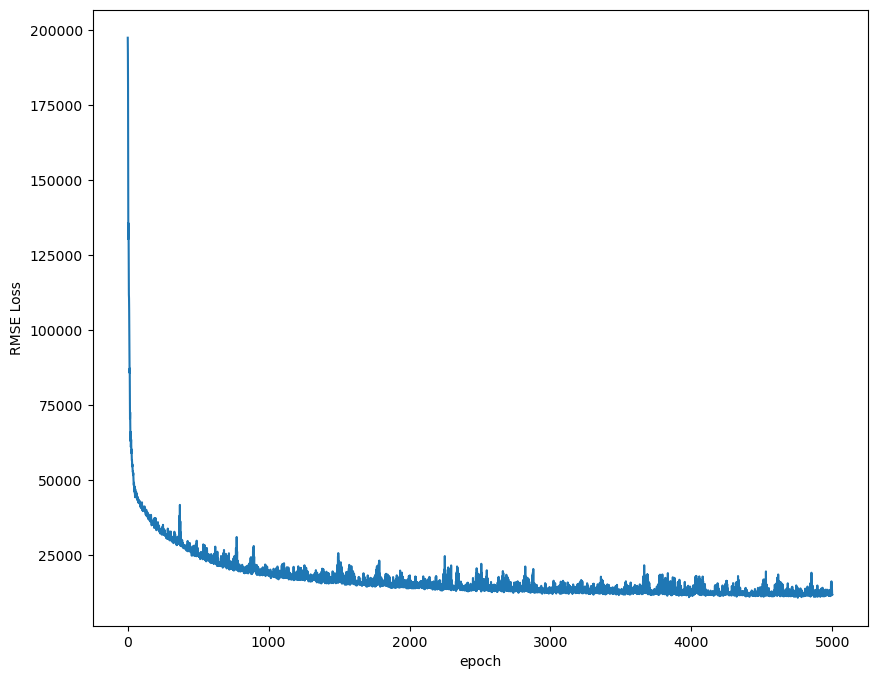

In [31]:
plt.plot(range(EPOCHS), final_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [32]:
test_set = torch.tensor(final_df[df_train.shape[0]:].values,dtype=torch.float32)
preds = []
for i in range(30):
    pred=model(test_set)
    preds.append(pred)
pred = torch.mean(torch.stack(preds),dim=0).detach()
print(pred)
pred = pred.detach().cpu() 

tensor([[126813.0469],
        [159490.7188],
        [192457.1875],
        ...,
        [195352.4219],
        [139518.8125],
        [223786.3594]])


In [33]:
sample_submission_df = pd.read_csv('house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = pred
sample_submission_df.to_csv('submission3.csv', index=False)
sample_submission_df.head()

,Id,SalePrice
0,1461,126813.046875
1,1462,159490.718750
2,1463,192457.187500
3,1464,206241.453125
4,1465,190761.062500


## `Score in Kaggle`
### Score: 0.16109 